# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


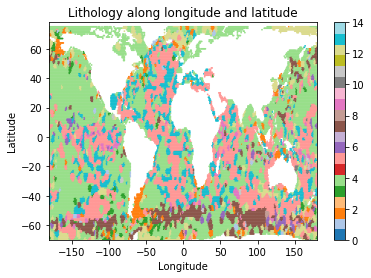

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

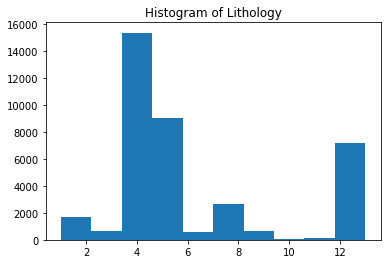

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [8]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [7]:
training_data = dfdata.copy()

# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Hidden layer 2: consists of 64 nerons
- Hidden layer 3: consists of 32 nerons
- Output layer

In [9]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
dropout_ratio = 0.1
initializer = "random_uniform"
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
prediction = Dense(32, activation="softmax", kernel_initializer=initializer)(layer)



history = History()


# define baseline model
def baseline_model():
    activation = "relu"
    dropout_ratio = 0.1
    initializer = "random_uniform"
    numclass = dummy_Y.shape[1]
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(64, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(32, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    
    # compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model



In [ ]:
# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

# training -> cross validation
nepochs = 50
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=True,
                           class_weight=weight)
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_predict(estimator, X, dummy_Y, cv=kfold)

In [ ]:
print("Accuracy = {}".format(accuracy_score(Y, results)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(results + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, y, "Actual lithology")
draw_global(lon, lat, results + 1, "Predicted lithology")